## LangGraph Open Deep Research - Supervisor-Researcher Architecture

In this notebook, we'll explore the **supervisor-researcher delegation architecture** for conducting deep research with LangGraph.

You can visit this repository to see the original application: [Open Deep Research](https://github.com/langchain-ai/open_deep_research)

Let's jump in!

## What We're Building

This implementation uses a **hierarchical delegation pattern** where:

1. **User Clarification** - Optionally asks clarifying questions to understand the research scope
2. **Research Brief Generation** - Transforms user messages into a structured research brief
3. **Supervisor** - A lead researcher that analyzes the brief and delegates research tasks
4. **Parallel Researchers** - Multiple sub-agents that conduct focused research simultaneously
5. **Research Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings are combined into a comprehensive report

![Architecture Diagram](https://i.imgur.com/Q8HEZn0.png)

This differs from a section-based approach by allowing dynamic task decomposition based on the research question, rather than predefined sections.

---

# 🤝 Breakout Room #1
## Deep Research Foundations

In this breakout room, we'll understand the architecture and components of the Open Deep Research system.

## Task 1: Dependencies

You'll need API keys for Anthropic (for the LLM) and Tavily (for web search). We'll configure the system to use Anthropic's Claude Sonnet 4 exclusively.

In [1]:
import os
import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

## Task 2: State Definitions

The state structure is hierarchical with three levels:

### Agent State (Top Level)
Contains the overall conversation messages, research brief, accumulated notes, and final report.

### Supervisor State (Middle Level)
Manages the research supervisor's messages, research iterations, and coordinating parallel researchers.

### Researcher State (Bottom Level)
Each individual researcher has their own message history, tool call iterations, and research findings.

We also have structured outputs for tool calling:
- **ConductResearch** - Tool for supervisor to delegate research to a sub-agent
- **ResearchComplete** - Tool to signal research phase is done
- **ClarifyWithUser** - Structured output for asking clarifying questions
- **ResearchQuestion** - Structured output for the research brief

Let's import these from our library: [`open_deep_library/state.py`](open_deep_library/state.py)

In [2]:
# Import state definitions from the library
from open_deep_library.state import (
    # Main workflow states
    AgentState,           # Lines 65-72: Top-level agent state with messages, research_brief, notes, final_report
    AgentInputState,      # Lines 62-63: Input state is just messages
    
    # Supervisor states
    SupervisorState,      # Lines 74-81: Supervisor manages research delegation and iterations
    
    # Researcher states
    ResearcherState,      # Lines 83-90: Individual researcher with messages and tool iterations
    ResearcherOutputState, # Lines 92-96: Output from researcher (compressed research + raw notes)
    
    # Structured outputs for tool calling
    ConductResearch,      # Lines 15-19: Tool for delegating research to sub-agents
    ResearchComplete,     # Lines 21-22: Tool to signal research completion
    ClarifyWithUser,      # Lines 30-41: Structured output for user clarification
    ResearchQuestion,     # Lines 43-48: Structured output for research brief
)

## Task 3: Utility Functions and Tools

The system uses several key utilities:

### Search Tools
- **tavily_search** - Async web search with automatic summarization to stay within token limits
- Supports Anthropic native web search and Tavily API

### Reflection Tools
- **think_tool** - Allows researchers to reflect on their progress and plan next steps (ReAct pattern)

### Helper Utilities
- **get_all_tools** - Assembles the complete toolkit (search + MCP + reflection)
- **get_today_str** - Provides current date context for research
- Token limit handling utilities for graceful degradation

These are defined in [`open_deep_library/utils.py`](open_deep_library/utils.py)

In [3]:
# Import utility functions and tools from the library
from open_deep_library.utils import (
    # Search tool - Lines 43-136: Tavily search with automatic summarization
    tavily_search,
    
    # Reflection tool - Lines 219-244: Strategic thinking tool for ReAct pattern
    think_tool,
    
    # Tool assembly - Lines 569-597: Get all configured tools
    get_all_tools,
    
    # Date utility - Lines 872-879: Get formatted current date
    get_today_str,
    
    # Supporting utilities for error handling
    get_api_key_for_model,          # Lines 892-914: Get API keys from config or env
    is_token_limit_exceeded,         # Lines 665-701: Detect token limit errors
    get_model_token_limit,           # Lines 831-846: Look up model's token limit
    remove_up_to_last_ai_message,    # Lines 848-866: Truncate messages for retry
    anthropic_websearch_called,      # Lines 607-637: Detect Anthropic native search usage
    openai_websearch_called,         # Lines 639-658: Detect OpenAI native search usage
    get_notes_from_tool_calls,       # Lines 599-601: Extract notes from tool messages
)

## Task 4: Configuration System

The configuration system controls:

### Research Behavior
- **allow_clarification** - Whether to ask clarifying questions before research
- **max_concurrent_research_units** - How many parallel researchers can run (default: 5)
- **max_researcher_iterations** - How many times supervisor can delegate research (default: 6)
- **max_react_tool_calls** - Tool call limit per researcher (default: 10)

### Model Configuration
- **research_model** - Model for research and supervision (we'll use Anthropic)
- **compression_model** - Model for synthesizing findings
- **final_report_model** - Model for writing the final report
- **summarization_model** - Model for summarizing web search results

### Search Configuration
- **search_api** - Which search API to use (ANTHROPIC, TAVILY, or NONE)
- **max_content_length** - Character limit before summarization

Defined in [`open_deep_library/configuration.py`](open_deep_library/configuration.py)

In [4]:
# Import configuration from the library
from open_deep_library.configuration import (
    Configuration,    # Lines 38-247: Main configuration class with all settings
    SearchAPI,        # Lines 11-17: Enum for search API options (ANTHROPIC, TAVILY, NONE)
)

## Task 5: Prompt Templates

The system uses carefully engineered prompts for each phase:

### Phase 1: Clarification
**clarify_with_user_instructions** - Analyzes if the research scope is clear or needs clarification

### Phase 2: Research Brief
**transform_messages_into_research_topic_prompt** - Converts user messages into a detailed research brief

### Phase 3: Supervisor
**lead_researcher_prompt** - System prompt for the supervisor that manages delegation strategy

### Phase 4: Researcher
**research_system_prompt** - System prompt for individual researchers conducting focused research

### Phase 5: Compression
**compress_research_system_prompt** - Prompt for synthesizing research findings without losing information

### Phase 6: Final Report
**final_report_generation_prompt** - Comprehensive prompt for writing the final report

All prompts are defined in [`open_deep_library/prompts.py`](open_deep_library/prompts.py)

In [5]:
# Import prompt templates from the library
from open_deep_library.prompts import (
    clarify_with_user_instructions,                    # Lines 3-41: Ask clarifying questions
    transform_messages_into_research_topic_prompt,     # Lines 44-77: Generate research brief
    lead_researcher_prompt,                            # Lines 79-136: Supervisor system prompt
    research_system_prompt,                            # Lines 138-183: Researcher system prompt
    compress_research_system_prompt,                   # Lines 186-222: Research compression prompt
    final_report_generation_prompt,                    # Lines 228-308: Final report generation
)

## ❓ Question #1:

Explain the interrelationships between the three states (Agent, Supervisor, Researcher). Why don't we just make a single huge state?

##### Answer:
agents(handles): user query, tool output, reasoning steps. Researcher(library) : sources collected, notes extracted from sources, structured facts. Supervisor (the brain) : which stage? what tasks remain, whether loop again or stop, quality checks. Supervisor : controls and strategize - decides on research or not, tracks tasks, basically keeping an eye on the researcher. Researcher : gathers information, stores sources, extract facts - making sure agent has things that it needs to proceed within a task. Agents : holds the rights cards if you will. Has user query, associated tools. Supervisor keeps track of its agents to make sure agent performs as stated. Why not single state : It may become chaotic, robust. Hard to keep track of everything in one window. Every state has its rrespective scope designated. 'Memory bleed' is a serious negative action which may affect the model's scope. We dont want heavy traffic to clutter the system. Clean code as they say to keep things all in tact.


## ❓ Question #2:

What are the advantages and disadvantages of importing these components instead of including them in the notebook?

##### Answer:
Advantages : keeping clean environment. Clean code easier to understand, which leads to easy debugging/ testing. Make it possible to reuse in other notebooks. Bottom line keeping it well structured/ organized. Disadvantage : It adds more layer in terms of difficult to navigate. Folder structure may get messy. Notebook is easy to experiment.


## 🏗️ Activity #1: Explore the Prompts

Open `open_deep_library/prompts.py` and examine one of the prompt templates in detail.

**Requirements:**
1. Choose one prompt template (clarify, brief, supervisor, researcher, compression, or final report)
2. Explain what the prompt is designed to accomplish
3. Identify 2-3 key techniques used in the prompt (e.g., structured output, role definition, examples)
4. Suggest one improvement you might make to the prompt

**YOUR CODE HERE** - Write your analysis in a markdown cell 
'clarify_with_user_instructions' - This prompt is designed for help model act alike a bookkeeper. This is for the model to look at the conversation history with date, checks if user's request is within the scope. Ask any questions pertaining to the user request or continue with the response generation. The respond is in JSON, so other files can have access to it. - This step is like clarification/ decision step. 2. Keeping a separate JSON file is clean code practice. This file can be injected into any other workflow if needed. 3. Maybe ask clarification if needed, ask at most one question, or at most 2 bullet points, because it says 'be concise' - this may confuse model.

---

# 🤝 Breakout Room #2
## Building & Running the Researcher

In this breakout room, we'll explore the node functions, build the graph, and run wellness research.

## Task 6: Node Functions - The Building Blocks

Now let's look at the node functions that make up our graph. We'll import them from the library and understand what each does.

### The Complete Research Workflow

The workflow consists of 8 key nodes organized into 3 subgraphs:

1. **Main Graph Nodes:**
   - `clarify_with_user` - Entry point that checks if clarification is needed
   - `write_research_brief` - Transforms user input into structured research brief
   - `final_report_generation` - Synthesizes all research into final report

2. **Supervisor Subgraph Nodes:**
   - `supervisor` - Lead researcher that plans and delegates
   - `supervisor_tools` - Executes supervisor's tool calls (delegation, reflection)

3. **Researcher Subgraph Nodes:**
   - `researcher` - Individual researcher conducting focused research
   - `researcher_tools` - Executes researcher's tool calls (search, reflection)
   - `compress_research` - Synthesizes researcher's findings

All nodes are defined in [`open_deep_library/deep_researcher.py`](open_deep_library/deep_researcher.py)

### Node 1: clarify_with_user

**Purpose:** Analyzes user messages and asks clarifying questions if the research scope is unclear.

**Key Steps:**
1. Check if clarification is enabled in configuration
2. Use structured output to analyze if clarification is needed
3. If needed, end with a clarifying question for the user
4. If not needed, proceed to research brief with verification message

**Implementation:** [`open_deep_library/deep_researcher.py` lines 60-115](open_deep_library/deep_researcher.py#L60-L115)

In [6]:
# Import the clarify_with_user node
from open_deep_library.deep_researcher import clarify_with_user

### Node 2: write_research_brief

**Purpose:** Transforms user messages into a structured research brief for the supervisor.

**Key Steps:**
1. Use structured output to generate detailed research brief from messages
2. Initialize supervisor with system prompt and research brief
3. Set up supervisor messages with proper context

**Why this matters:** A well-structured research brief helps the supervisor make better delegation decisions.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 118-175](open_deep_library/deep_researcher.py#L118-L175)

In [7]:
# Import the write_research_brief node
from open_deep_library.deep_researcher import write_research_brief

### Node 3: supervisor

**Purpose:** Lead research supervisor that plans research strategy and delegates to sub-researchers.

**Key Steps:**
1. Configure model with three tools:
   - `ConductResearch` - Delegate research to a sub-agent
   - `ResearchComplete` - Signal that research is done
   - `think_tool` - Strategic reflection before decisions
2. Generate response based on current context
3. Increment research iteration count
4. Proceed to tool execution

**Decision Making:** The supervisor uses `think_tool` to reflect before delegating research, ensuring thoughtful decomposition of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 178-223](open_deep_library/deep_researcher.py#L178-L223)

In [8]:
# Import the supervisor node (from supervisor subgraph)
from open_deep_library.deep_researcher import supervisor

### Node 4: supervisor_tools

**Purpose:** Executes the supervisor's tool calls, including strategic thinking and research delegation.

**Key Steps:**
1. Check exit conditions:
   - Exceeded maximum iterations
   - No tool calls made
   - `ResearchComplete` called
2. Process `think_tool` calls for strategic reflection
3. Execute `ConductResearch` calls in parallel:
   - Spawn researcher subgraphs for each delegation
   - Limit to `max_concurrent_research_units` (default: 5)
   - Gather all results asynchronously
4. Aggregate findings and return to supervisor

**Parallel Execution:** This is where the magic happens - multiple researchers work simultaneously on different aspects of the research question.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 225-349](open_deep_library/deep_researcher.py#L225-L349)

In [9]:
# Import the supervisor_tools node
from open_deep_library.deep_researcher import supervisor_tools

### Node 5: researcher

**Purpose:** Individual researcher that conducts focused research on a specific topic.

**Key Steps:**
1. Load all available tools (search, MCP, reflection)
2. Configure model with tools and researcher system prompt
3. Generate response with tool calls
4. Increment tool call iteration count

**ReAct Pattern:** Researchers use `think_tool` to reflect after each search, deciding whether to continue or provide their answer.

**Available Tools:**
- Search tools (Tavily or Anthropic native search)
- `think_tool` for strategic reflection
- `ResearchComplete` to signal completion
- MCP tools (if configured)

**Implementation:** [`open_deep_library/deep_researcher.py` lines 365-424](open_deep_library/deep_researcher.py#L365-L424)

In [10]:
# Import the researcher node (from researcher subgraph)
from open_deep_library.deep_researcher import researcher

### Node 6: researcher_tools

**Purpose:** Executes the researcher's tool calls, including searches and strategic reflection.

**Key Steps:**
1. Check early exit conditions (no tool calls, native search used)
2. Execute all tool calls in parallel:
   - Search tools fetch and summarize web content
   - `think_tool` records strategic reflections
   - MCP tools execute external integrations
3. Check late exit conditions:
   - Exceeded `max_react_tool_calls` (default: 10)
   - `ResearchComplete` called
4. Continue research loop or proceed to compression

**Error Handling:** Safely handles tool execution errors and continues with available results.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 435-509](open_deep_library/deep_researcher.py#L435-L509)

In [11]:
# Import the researcher_tools node
from open_deep_library.deep_researcher import researcher_tools

### Node 7: compress_research

**Purpose:** Compresses and synthesizes research findings into a concise, structured summary.

**Key Steps:**
1. Configure compression model
2. Add compression instruction to messages
3. Attempt compression with retry logic:
   - If token limit exceeded, remove older messages
   - Retry up to 3 times
4. Extract raw notes from tool and AI messages
5. Return compressed research and raw notes

**Why Compression?** Researchers may accumulate lots of tool outputs and reflections. Compression ensures:
- All important information is preserved
- Redundant information is deduplicated
- Content stays within token limits for the final report

**Token Limit Handling:** Gracefully handles token limit errors by progressively truncating messages.

**Implementation:** [`open_deep_library/deep_researcher.py` lines 511-585](open_deep_library/deep_researcher.py#L511-L585)

In [12]:
# Import the compress_research node
from open_deep_library.deep_researcher import compress_research

### Node 8: final_report_generation

**Purpose:** Generates the final comprehensive research report from all collected findings.

**Key Steps:**
1. Extract all notes from completed research
2. Configure final report model
3. Attempt report generation with retry logic:
   - If token limit exceeded, truncate findings by 10%
   - Retry up to 3 times
4. Return final report or error message

**Token Limit Strategy:**
- First retry: Use model's token limit × 4 as character limit
- Subsequent retries: Reduce by 10% each time
- Graceful degradation with helpful error messages

**Report Quality:** The prompt guides the model to create well-structured reports with:
- Proper headings and sections
- Inline citations
- Comprehensive coverage of all findings
- Sources section at the end

**Implementation:** [`open_deep_library/deep_researcher.py` lines 607-697](open_deep_library/deep_researcher.py#L607-L697)

In [19]:
# Import the final_report_generation node
from open_deep_library.deep_researcher import final_report_generation

## Task 7: Graph Construction - Putting It All Together

The system is organized into three interconnected graphs:

### 1. Researcher Subgraph (Bottom Level)
Handles individual focused research on a specific topic:
```
START → researcher → researcher_tools → compress_research → END
               ↑            ↓
               └────────────┘ (loops until max iterations or ResearchComplete)
```

### 2. Supervisor Subgraph (Middle Level)
Manages research delegation and coordination:
```
START → supervisor → supervisor_tools → END
            ↑              ↓
            └──────────────┘ (loops until max iterations or ResearchComplete)
            
supervisor_tools spawns multiple researcher_subgraphs in parallel
```

### 3. Main Deep Researcher Graph (Top Level)
Orchestrates the complete research workflow:
```
START → clarify_with_user → write_research_brief → research_supervisor → final_report_generation → END
                 ↓                                       (supervisor_subgraph)
               (may end early if clarification needed)
```

Let's import the compiled graphs from the library.

In [18]:
# Import the pre-compiled graphs from the library
from open_deep_library.deep_researcher import (
    # Bottom level: Individual researcher workflow
    researcher_subgraph,    # Lines 588-605: researcher → researcher_tools → compress_research
    
    # Middle level: Supervisor coordination
    supervisor_subgraph,    # Lines 351-363: supervisor → supervisor_tools (spawns researchers)
    
    # Top level: Complete research workflow
    deep_researcher,        # Lines 699-719: Main graph with all phases
)

## Why This Architecture?

### Advantages of Supervisor-Researcher Delegation

1. **Dynamic Task Decomposition**
   - Unlike section-based approaches with predefined structure, the supervisor can break down research based on the actual question
   - Adapts to different types of research (comparisons, lists, deep dives, etc.)

2. **Parallel Execution**
   - Multiple researchers work simultaneously on different aspects
   - Much faster than sequential section processing
   - Configurable parallelism (1-20 concurrent researchers)

3. **ReAct Pattern for Quality**
   - Researchers use `think_tool` to reflect after each search
   - Prevents excessive searching and improves search quality
   - Natural stopping conditions based on information sufficiency

4. **Flexible Tool Integration**
   - Easy to add MCP tools for specialized research
   - Supports multiple search APIs (Anthropic, Tavily)
   - Each researcher can use different tool combinations

5. **Graceful Token Limit Handling**
   - Compression prevents token overflow
   - Progressive truncation in final report generation
   - Research can scale to arbitrary depths

### Trade-offs

- **Complexity:** More moving parts than section-based approach
- **Cost:** Parallel researchers use more tokens (but faster)
- **Unpredictability:** Research structure emerges dynamically

## Task 8: Running the Deep Researcher

Now let's see the system in action! We'll use it to research wellness strategies for improving sleep quality.

### Setup

We need to:
1. Set up the wellness research request
2. Configure the execution with Anthropic settings
3. Run the research workflow

In [15]:
# Set up the graph with Anthropic configuration
from IPython.display import Markdown, display
import uuid

# Note: deep_researcher is already compiled from the library
# For this demo, we'll use it directly without additional checkpointing
graph = deep_researcher

print("✓ Graph ready for execution")
print("  (Note: The graph is pre-compiled from the library)")

✓ Graph ready for execution
  (Note: The graph is pre-compiled from the library)


### Configuration for Anthropic

We'll configure the system to use:
- **Claude Sonnet 4** for all research, supervision, and report generation
- **Tavily** for web search (you can also use Anthropic's native search)
- **Moderate parallelism** (1 concurrent researcher for cost control)
- **Clarification enabled** (will ask if research scope is unclear)

In [16]:
# Configure for Anthropic with moderate settings
config = {
    "configurable": {
        # Model configuration - using Claude Sonnet 4 for everything
        "research_model": "anthropic:claude-sonnet-4-20250514",
        "research_model_max_tokens": 10000,
        
        "compression_model": "anthropic:claude-sonnet-4-20250514",
        "compression_model_max_tokens": 8192,
        
        "final_report_model": "anthropic:claude-sonnet-4-20250514",
        "final_report_model_max_tokens": 10000,
        
        "summarization_model": "anthropic:claude-sonnet-4-20250514",
        "summarization_model_max_tokens": 8192,
        
        # Research behavior
        "allow_clarification": True,
        "max_concurrent_research_units": 1,  # 1 parallel researcher
        "max_researcher_iterations": 2,      # Supervisor can delegate up to 2 times
        "max_react_tool_calls": 3,           # Each researcher can make up to 3 tool calls
        
        # Search configuration
        "search_api": "tavily",  # Using Tavily for web search
        "max_content_length": 50000,
        
        # Thread ID for this conversation
        "thread_id": str(uuid.uuid4())
    }
}

print("✓ Configuration ready")
print(f"  - Research Model: Claude Sonnet 4")
print(f"  - Max Concurrent Researchers: 1")
print(f"  - Max Iterations: 2")
print(f"  - Search API: Tavily")

✓ Configuration ready
  - Research Model: Claude Sonnet 4
  - Max Concurrent Researchers: 1
  - Max Iterations: 2
  - Search API: Tavily


### Execute the Wellness Research

Now let's run the research! We'll ask the system to research evidence-based strategies for improving sleep quality.

The workflow will:
1. **Clarify** - Check if the request is clear (may skip if obvious)
2. **Research Brief** - Transform our request into a structured brief
3. **Supervisor** - Plan research strategy and delegate to researchers
4. **Parallel Research** - Researchers gather information simultaneously
5. **Compression** - Each researcher synthesizes their findings
6. **Final Report** - All findings combined into comprehensive report

In [17]:
# Create our wellness research request
research_request = """
I want to improve my sleep quality. I currently:
- Go to bed at inconsistent times (10pm-1am)
- Use my phone in bed
- Often feel tired in the morning

Please research the best evidence-based strategies for improving sleep quality and create a comprehensive sleep improvement plan for me.
"""

# Execute the graph
async def run_research():
    """Run the research workflow and display results."""
    print("Starting research workflow...\n")
    
    async for event in graph.astream(
        {"messages": [{"role": "user", "content": research_request}]},
        config,
        stream_mode="updates"
    ):
        # Display each step
        for node_name, node_output in event.items():
            print(f"\n{'='*60}")
            print(f"Node: {node_name}")
            print(f"{'='*60}")
            
            if node_name == "clarify_with_user":
                if "messages" in node_output:
                    last_msg = node_output["messages"][-1]
                    print(f"\n{last_msg.content}")
            
            elif node_name == "write_research_brief":
                if "research_brief" in node_output:
                    print(f"\nResearch Brief Generated:")
                    print(f"{node_output['research_brief'][:500]}...")
            
            elif node_name == "supervisor":
                print(f"\nSupervisor planning research strategy...")
                if "supervisor_messages" in node_output:
                    last_msg = node_output["supervisor_messages"][-1]
                    if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
                        print(f"Tool calls: {len(last_msg.tool_calls)}")
                        for tc in last_msg.tool_calls:
                            print(f"  - {tc['name']}")
            
            elif node_name == "supervisor_tools":
                print(f"\nExecuting supervisor's tool calls...")
                if "notes" in node_output:
                    print(f"Research notes collected: {len(node_output['notes'])}")
            
            elif node_name == "final_report_generation":
                if "final_report" in node_output:
                    print(f"\n" + "="*60)
                    print("FINAL REPORT GENERATED")
                    print("="*60 + "\n")
                    display(Markdown(node_output["final_report"]))
    
    print("\n" + "="*60)
    print("Research workflow completed!")
    print("="*60)

# Run the research
await run_research()

Starting research workflow...


Node: clarify_with_user

I have sufficient information to proceed with your sleep quality improvement research. Based on your request, I understand you want evidence-based strategies to address your current challenges: inconsistent bedtimes (10pm-1am range), phone use in bed, and morning fatigue. I will now research comprehensive, science-backed sleep improvement strategies and create a personalized plan to help you achieve better sleep quality and wake up feeling more rested.

Node: write_research_brief

Research Brief Generated:
I want to improve my sleep quality based on evidence-based strategies. My current sleep challenges include: going to bed at inconsistent times (ranging from 10pm to 1am), using my phone in bed, and often feeling tired in the morning despite getting sleep. Please research comprehensive, science-backed sleep improvement strategies that specifically address these issues. I need a detailed sleep improvement plan that includes: (1) 


Node: research_supervisor

Node: final_report_generation

FINAL REPORT GENERATED



# Evidence-Based Sleep Improvement Plan: A Comprehensive Strategy for Better Sleep Quality

## Sleep Schedule Consistency and Circadian Rhythm Regulation

The foundation of quality sleep begins with maintaining consistent sleep timing. The American Academy of Sleep Medicine (AASM) recommends that adults get 7 or more hours of sleep per night on a regular basis to promote optimal health [1]. Your current inconsistent bedtime pattern (10pm-1am range) is disrupting your circadian rhythm, which requires regularity to function optimally.

**Implementing a Consistent Sleep Schedule:**

Start by choosing a realistic target bedtime that allows for 7-8 hours of sleep before your required wake time. Given your current range, consider 11:00 PM as an initial target. Use the "15-minute rule" for gradual adjustment - shift your bedtime by 15 minutes earlier every few days rather than making drastic changes [2]. This gradual approach prevents shock to your system and improves compliance.

Most importantly, maintain a fixed wake-up time regardless of weekday or weekend [3]. This consistency is crucial for circadian rhythm regulation and will naturally help regulate your bedtime over time. Sleep improvements typically take 2-4 weeks to become noticeable as your body needs time to adjust to new routines and rhythms [2].

## Strategic Screen Time Reduction and Blue Light Management

Your habit of using your phone in bed is significantly impacting your sleep quality through blue light exposure and mental stimulation. Blue light in the 450-480 nm range is especially potent at suppressing melatonin and enhancing alertness [4]. Research from 2021 showed that just 2 hours of evening light exposure from an LED tablet caused a 55% decrease in melatonin and an average 1.5-hour delay in melatonin onset compared to reading a printed book [5].

**Actionable Screen Time Strategies:**

Implement a complete digital sunset 30-60 minutes before your target bedtime. This means all electronic devices - phones, tablets, computers, and TVs - should be powered down and removed from the bedroom entirely [6]. Research shows that even having a device in the bedroom, whether in use or not, has been linked to reduced sleep duration and increased daytime sleepiness [6].

Create a phone charging station outside your bedroom to eliminate the temptation for late-night scrolling. Replace your phone alarm with a traditional alarm clock to remove the excuse for keeping your device bedside. If you must use devices in the evening hours before your digital sunset, activate built-in blue light filters, though complete avoidance is preferable.

## Comprehensive Bedtime Routine Development

A structured bedtime routine lasting 30-60 minutes signals your brain that it's time for sleep [4]. This routine should incorporate multiple relaxation techniques and prepare your body for rest.

**30-60 Minute Pre-Sleep Routine:**

Begin with putting away all electronics at the start of your routine. Take a warm bath at least one hour before bed - this mimics the natural drop in body temperature that promotes sleepiness [4]. Follow this with gentle stretching, deep breathing exercises, progressive muscle relaxation, or light yoga to release physical and mental tension.

Consider keeping a journal or creating tomorrow's to-do list during this time. Research found that taking just five minutes before bed to jot down tasks for the following days significantly sped up sleep onset [4]. This "brain dump" technique helps clear worries and mental clutter that can interfere with falling asleep.

Reading a simple, uneventful book outside the bedroom under soft lighting can also be beneficial, but ensure the content isn't stimulating or work-related.

## Morning Light Exposure and Energy Enhancement

Your morning fatigue likely stems from poor circadian rhythm regulation and sleep inertia. Morning sunlight exposure is crucial for setting your biological clock and improving overall sleep quality.

**Strategic Morning Light Protocol:**

Get outside within 30-60 minutes of waking for at least 10-15 minutes of sunlight exposure without sunglasses or glass barriers [7]. Face the sun indirectly with your eyes open - this is about light entering your eyes to trigger circadian responses, not tanning your skin. Even on cloudy days, outdoor light is significantly stronger than indoor lighting and will provide the necessary stimulus.

Research from Brazil found that every 30-minute increment of morning sun exposure before 10 a.m. was associated with a 23-minute reduction in sleep midpoint and significantly improved sleep quality scores [8]. The CDC recommends at least 30 minutes of safe sunlight exposure during daytime hours, ideally in the morning [5].

## Combat Morning Fatigue and Sleep Inertia

Sleep inertia - the grogginess, disorientation, and cognitive impairment immediately following waking - typically lasts 15-60 minutes but can extend for hours if not properly managed [9].

**Morning Alertness Strategies:**

Implement a gradual wake-up process using a sunrise alarm clock that mimics natural dawn by gradually increasing light intensity. This helps your brain ease into wakefulness rather than being abruptly forced into alertness [10].

Immediately upon waking, drink water to combat overnight dehydration, which worsens fatigue and brain fog [10]. Follow this with 5 minutes of physical movement - even light stretching or walking increases circulation and oxygen flow, helping shake off grogginess faster.

For enhanced morning alertness, consider bright light therapy using appropriately timed exposure of 30-90 minutes to help regulate your biological clock [1]. Research on light-emitting devices shows significant improvements in self-rated alertness and energy levels [11].

## Sleep Environment Optimization

Your sleep environment plays a crucial role in sleep quality and should be optimized for temperature, light, and sound control.

**Environmental Modifications:**

Maintain bedroom temperature between 65-68°F (18-20°C) at night, as most people sleep better in slightly cool conditions [6]. Install blackout curtains or use eye masks to block external light sources, and dim all lights in your home 2 hours before bedtime to support natural melatonin production [10].

Address noise issues with earplugs, white noise machines, or fans. Heavy curtains and rugs can help absorb sound from outside sources [6]. Reserve your bedroom exclusively for sleep and intimacy - remove work materials, exercise equipment, and entertainment devices to strengthen the mental association between your bedroom and sleep.

## Additional Evidence-Based Sleep Hygiene Practices

**Nutrition and Timing:**
Finish eating meals at least 2-3 hours before bedtime, as your body cannot rest effectively while digesting large meals [4]. Avoid caffeine after 2 PM, given its 6-hour half-life and ability to affect sleep up to 8 hours after consumption [2,6]. Limit alcohol consumption near bedtime, as it becomes stimulating after initial sedation wears off and reduces REM sleep quality [6].

**Exercise Guidelines:**
Engage in at least 10 minutes of daily physical activity, which can improve sleep quality and overall health [5]. However, avoid vigorous exercise within two hours of bedtime for most people, though individual tolerance varies [6].

**Strategic Napping:**
If napping is necessary, limit sessions to 20 minutes or less and complete them before 3:00 PM to avoid interfering with nighttime sleep [9]. Longer or later naps can increase sleep inertia and make evening sleep onset more difficult.

**Sleep Tracking and Monitoring:**
Maintain a sleep diary for at least two weeks, recording bedtime, wake time, medications, caffeine/alcohol consumption, meal timing, exercise duration, and electronic device usage [6]. Track morning assessments of sleep quality and duration to identify patterns between behaviors and sleep outcomes.

**Stress Management:**
Implement stress reduction techniques such as writing down worries in a notepad before bed, practicing progressive muscle relaxation, or using 4-7-8 breathing exercises [2]. These techniques help clear mental clutter and prepare your mind for rest.

This comprehensive approach addresses all your specific challenges while providing a foundation for long-term sleep quality improvement. Remember that consistency is key, and changes should be implemented gradually for the best chance of long-term success.

### Sources

[1] American Academy of Sleep Medicine: Recommended amount of sleep for a healthy adult: https://aasm.org/resources/pdf/pressroom/adult-sleep-duration-consensus.pdf

[2] The Sleep People: 7 Science-Backed Tips for Better Sleep Quality in 2025: https://www.thesleeppeople.co.uk/blogs/sleep-health-wellness/7-science-backed-tips-for-better-sleep-quality-in-2025

[3] Healthline: 12 Tips for Better Sleep Hygiene: https://www.healthline.com/health/sleep-hygiene

[4] Sleep Foundation: How to Build a Better Bedtime Routine for Adults: https://www.sleepfoundation.org/sleep-hygiene/bedtime-routine-for-adults

[5] Bayhealth Medical Center: The Science and Strategies Behind a Better Night's Rest: https://www.bayhealth.org/community-wellness/blog/2025/june/better-sleep

[6] Harvard Health Publishing: Sleep hygiene: Simple practices for better rest: https://www.health.harvard.edu/staying-healthy/sleep-hygiene-simple-practices-for-better-rest

[7] Banner Health: Sun Gating and Morning Light for Better Sleep: https://www.bannerhealth.com/healthcareblog/teach-me/sun-gating-and-morning-light-for-better-sleep

[8] PMC: The role of sunlight in sleep regulation: analysis of morning, evening and late exposure: https://pmc.ncbi.nlm.nih.gov/articles/PMC12502225/

[9] Sleep Foundation: Sleep Inertia: How to Combat Morning Grogginess: https://www.sleepfoundation.org/how-sleep-works/sleep-inertia

[10] Sleepless in Arizona: How to Overcome Sleep Inertia: Expert Tips: https://sleeplessinarizona.com/how-to-overcome-sleep-inertia-expert-tips/

[11] Science Direct: An at-home evaluation of a light intervention to mitigate sleep inertia: https://www.sciencedirect.com/science/article/pii/S2352721823001651


Research workflow completed!


## Task 9: Understanding the Output

Let's break down what happened:

### Phase 1: Clarification
The system checked if your request was clear. Since you provided specific details about your sleep issues, it likely proceeded without asking clarifying questions.

### Phase 2: Research Brief
Your request was transformed into a detailed research brief that guides the supervisor's delegation strategy.

### Phase 3: Supervisor Delegation
The supervisor analyzed the brief and decided how to break down the research:
- Used `think_tool` to plan strategy
- Called `ConductResearch` to delegate to researchers
- Each delegation specified a focused research topic (e.g., sleep hygiene, circadian rhythm, blue light effects)

### Phase 4: Parallel Research
Researchers worked on their assigned topics:
- Each researcher used web search tools to gather information
- Used `think_tool` to reflect after each search
- Decided when they had enough information
- Compressed their findings into clean summaries

### Phase 5: Final Report
All research findings were synthesized into a comprehensive sleep improvement plan with:
- Well-structured sections
- Evidence-based recommendations
- Practical action items
- Sources for further reading

## Task 10: Key Takeaways & Next Steps

### Architecture Benefits
1. **Dynamic Decomposition** - Research structure emerges from the question, not predefined
2. **Parallel Efficiency** - Multiple researchers work simultaneously
3. **ReAct Quality** - Strategic reflection improves search decisions
4. **Scalability** - Handles token limits gracefully through compression
5. **Flexibility** - Easy to add new tools and capabilities

### When to Use This Pattern
- **Complex research questions** that need multi-angle investigation
- **Comparison tasks** where parallel research on different topics is beneficial
- **Open-ended exploration** where structure should emerge dynamically
- **Time-sensitive research** where parallel execution speeds up results

### When to Use Section-Based Instead
- **Highly structured reports** with predefined format requirements
- **Template-based content** where sections are always the same
- **Sequential dependencies** where later sections depend on earlier ones
- **Budget constraints** where token efficiency is critical

### Extend the System
1. **Add MCP Tools** - Integrate specialized tools for your domain
2. **Custom Prompts** - Modify prompts for specific research types
3. **Different Models** - Try different Claude versions or mix models
4. **Persistence** - Use a real database for checkpointing instead of memory

### Learn More
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Open Deep Research Repo](https://github.com/langchain-ai/open_deep_research)
- [Anthropic Claude Documentation](https://docs.anthropic.com/)
- [Tavily Search API](https://tavily.com/)

## ❓ Question #3:

What are the trade-offs of using parallel researchers vs. sequential research? When might you choose one approach over the other?

##### Answer:
Parallel : Multi tasking is always goos to cover work in short period of time. Each researchers can do explore - gather- view - fact check at the same time. At the same time running multiple lines may tire the process, cost, tokens. What about responses being stale? Or repeating responses? I think there should be a middle man to capture information these multiple running researchers produce and maybe combine them with refreshed response, deleting unwanted stuff, yet again this may cost. Sequential : Chain of thoughts is not lost as each step depends on the previous step so there will be in depth research. No duplicate responses. Cost may not be high, tokens too. But this approach may be slower, no parallel work means each step has to be in waiting state. Whem to choose : Large topics need fast coverage hence use Parallel. When you may need other options to consider. Choose sequential when query is small, not difficult, cost is an issue. Also when one output depends on the other sequential works best. Actually it reminded me of Breath first search and Depth first search algorithms.


## ❓ Question #4:

How would you adapt this deep research architecture for a production wellness application? What additional components would you need?

##### Answer:
The three main pattern  - Agent, Supervisor, Researcher can be reliable, but needs to make it more safe and scalable. Agents becomes a response generrator. Supervisor becomes the manager. Researcher becomes like a RAG that pulls information from sources. But because Wellness app is a high risk domain, safety becomes critical. Real memory storage can be incorporated not just JSON. If its going into production evaluation is a seriuos check for hallucination/ unsafe outputs. Needs rigorous logging mechanism to have a full visibility on tool calls, retrieval logs, user feedbacks. Cost and latency control. 


## 🏗️ Activity #2: Custom Wellness Research

Using what you've learned, run a custom wellness research task.

**Requirements:**
1. Create a wellness-related research question (exercise, nutrition, stress, etc.)
2. Modify the configuration for your use case
3. Run the research and analyze the output
4. Document what worked well and what could be improved

**Experiment ideas:**
- Research exercise routines for specific conditions (bad knee, lower back pain)
- Compare different stress management techniques
- Investigate nutrition strategies for specific goals
- Explore meditation and mindfulness research

**YOUR CODE HERE**

In [5]:
import open_deep_library.deep_researcher as dr
dir(dr)


['AIMessage',
 'AgentInputState',
 'AgentState',
 'ClarifyWithUser',
 'Command',
 'ConductResearch',
 'Configuration',
 'END',
 'HumanMessage',
 'Literal',
 'ResearchComplete',
 'ResearchQuestion',
 'ResearcherOutputState',
 'ResearcherState',
 'RunnableConfig',
 'START',
 'StateGraph',
 'SupervisorState',
 'SystemMessage',
 'ToolMessage',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'anthropic_websearch_called',
 'asyncio',
 'clarify_with_user',
 'clarify_with_user_instructions',
 'compress_research',
 'compress_research_simple_human_message',
 'compress_research_system_prompt',
 'configurable_model',
 'deep_researcher',
 'deep_researcher_builder',
 'execute_tool_safely',
 'filter_messages',
 'final_report_generation',
 'final_report_generation_prompt',
 'get_all_tools',
 'get_api_key_for_model',
 'get_buffer_string',
 'get_model_token_limit',
 'get_notes_from_tool_calls',
 'get_today_str',
 

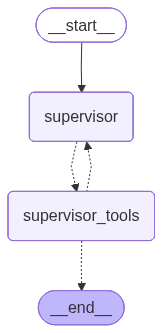

In [6]:
dr.supervisor_subgraph


In [7]:
from open_deep_library.deep_researcher import supervisor_subgraph


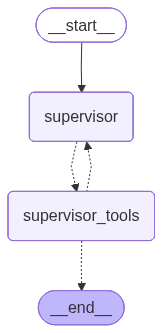

In [8]:
supervisor_subgraph


In [2]:
import uuid


In [34]:
import os, getpass
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


In [42]:
# YOUR CODE HERE
from langchain_core.messages import HumanMessage
from open_deep_library.deep_researcher import supervisor_subgraph      
# Create your own wellness research request and run it
my_wellness_request = """Research safe and evidence-based exercise routines for people with mild knee pain.
Create a structured guide with:
- 5–7 recommended exercises (low impact)
- What to avoid (common knee pain triggers)
- A 2-week beginner plan (3 days/week)
-I like dance classes, include like Zumba workout, maybe kickboxing for high intensity
- Safety tips and progression guidance
Keep the tone practical and beginner-friendly."""
# Optionally modify the config (tuned for this use case)
my_config = {
    "configurable": {
        "research_model": "openai:gpt-4o-mini",
        "research_model_max_tokens": 500,
        "compression_model": "openai:gpt-4o-mini",
        "compression_model_max_tokens": 500,
        "final_report_model": "openai:gpt-4o-mini",
        "final_report_model_max_tokens": 500,
        "summarization_model": "openai:gpt-4o-mini",
        "summarization_model_max_tokens": 500,
        "allow_clarification": True,
        "max_concurrent_research_units": 1,
        "max_researcher_iterations": 3,
        "max_react_tool_calls": 4,
        "search_api": "tavily",
        "max_content_length": 1000,
        "thread_id": str(uuid.uuid4())
    }
}

# Run your research
result = await supervisor_subgraph.ainvoke(
    {"supervisor_messages": [HumanMessage(content=my_wellness_request)]},
    config=my_config
)







In [ ]:
print(result["notes"][0][:2000])
#Observation : Imported prompts from the library which is in a different file. 
# Initially tried using the Anthropic claude sonnet model, kept getting errors because my environment 
# was not recognizing the model. I tried to change to the latest sonnet model, a different model, 
# or some reason it was not getting the model access. I was getting blocked by the model ID. 
# Things I tried : "anthropic:claude-3-sonnet-20240229", “anthropic:claude-3-5-sonnet-latest”. 
# Finally I used "openai:gpt-4o-mini". I got 25 pages of response output. Initially changed 
# a limit on tokens eg : "research_model_max_tokens": 8000, with the other 3 tokens,  
# then tried "research_model_max_tokens": 500 same with the rest. 


**List of Queries and Tool Calls Made**
1. Safe exercise routines for mild knee pain
2. Beginner-friendly low-impact exercises for knee pain
3. Knee pain triggers
4. Practical tips for knee pain exercise
5. Evidence-based exercises for knee pain
6. Low-impact workouts for beginners with knee issues
7. Progression tips for knee pain exercises
8. Beginner routines for knee pain
9. Safe progression exercises for knee pain
10. Exercise safety tips for knee pain
11. Detailed low-impact exercises for sore knees
12. Overcoming knee pain through exercise
13. Comprehensive knee pain exercise plans
14. Best practices for knee pain management during exercise

**Fully Comprehensive Findings**

A collection of sources details safe and evidence-based exercise routines tailored for individuals experiencing mild knee pain. The emphasis is on beginner-friendly, low-impact exercises designed to alleviate discomfort and improve mobility. 

1. Healthline offers "10 Visuals of Exercises to Help Relieve Kne